In [3]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.gridspec as gridspec
import seabornfig2grid as sfg


from scipy.stats import percentileofscore
from scipy import stats

import pymc3 as pm
import arviz as az

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scipy.stats as scs
from scipy.stats import norm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

### Business Idea: How Much Each Channel contribute to the Target?

#### Loading Data

In [6]:
data = pd.read_excel(r'x:\CAO\Team\Data Science\performance_link\Bet_Awards\data\bet_awards_modfile_FINAL_08.23.2021.xlsx')
# dma_code column assigned to region and can be dropped
data = data.drop(columns=['dma_code'])
# checking for Nan values in columns
print(data.isna().sum().sum())
data.head()

0


,cplx_imp_i,smsn_imp_i,spot_imp_i,vzio_imp_i,tw_imp_i,fb_imp_i,yt_imp_i,tv_exp_i,tune_in_i
0,0.008422,0.015025,0.212211,0.013772,0.348791,0.023189,0.119566,0.005713,0.050437
1,0.016431,0.036270,0.225445,0.007491,0.369489,0.046153,0.184742,0.010343,0.097058
2,0.006553,0.015509,0.178028,0.011686,0.344432,0.037104,0.141722,0.008395,0.132308
3,0.010626,0.017485,0.119478,0.013206,0.353738,0.095669,0.236077,0.022665,0.223991
4,0.016560,0.025442,0.204707,0.010759,0.370823,0.046618,0.321395,0.015143,0.130586


In [7]:
data.describe()

,cplx_imp_i,smsn_imp_i,spot_imp_i,vzio_imp_i,tw_imp_i,fb_imp_i,yt_imp_i,tv_exp_i,tune_in_i
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.008516,0.021490,0.180836,0.013638,0.352482,0.050132,0.175388,0.010169,0.091919
std,0.003937,0.008625,0.052792,0.009866,0.010691,0.018990,0.059557,0.004788,0.054194
min,0.001626,0.008018,0.074963,0.007491,0.334246,0.000000,0.071617,0.001961,0.000000
25%,0.005782,0.015603,0.147842,0.011492,0.344670,0.037052,0.138629,0.006756,0.056087
50%,0.007491,0.020142,0.172508,0.012958,0.350286,0.046479,0.161186,0.009065,0.083639
75%,0.010398,0.025903,0.211144,0.014160,0.357436,0.057383,0.195522,0.011949,0.119984
max,0.022324,0.058665,0.368853,0.150939,0.401953,0.139827,0.434015,0.024520,0.250879


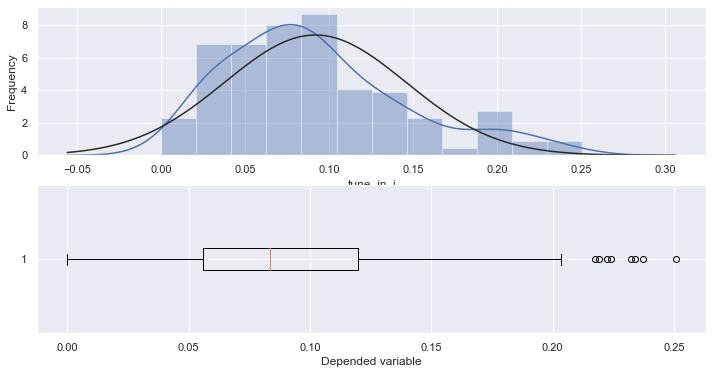

In [8]:
# Distribution of the target variable
target_distribution(data.tune_in_i, save =True, trace_name='imgs/target_distribution.png')

#### As we can tell Target variable is aproximatly Normally Distributed with mean = 0.09 and median = 0.08. As mean < median we observe right skewness

### Relationship between independent and dependent variable

### Check for Multicolinearity between independent variables

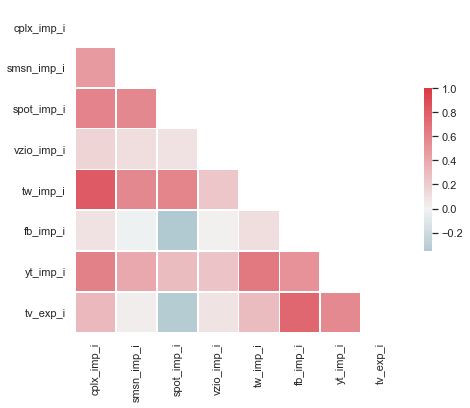

Based on threshold 0.8 , sugested featrures to drop - ['cplx_imp_i', 'tw_imp_i']


,cplx_imp_i,tw_imp_i
cplx_imp_i,1.000000,0.812304
tw_imp_i,0.812304,1.000000


In [19]:
features_corr_matrix(data.iloc[:,:-1], 0.8, matrix= True)

Multicollinearity will certainty effect the inference we make.

However, unlike in frequentist settings, the sampling process will not blow up. Instead, the ambiguity inherent in estimating coefficients of collinear predictors will show up as dependence in the posterior.

Estimation goes just fine, but there’s lots of ambiguity about the values of these parameters (as there should be).

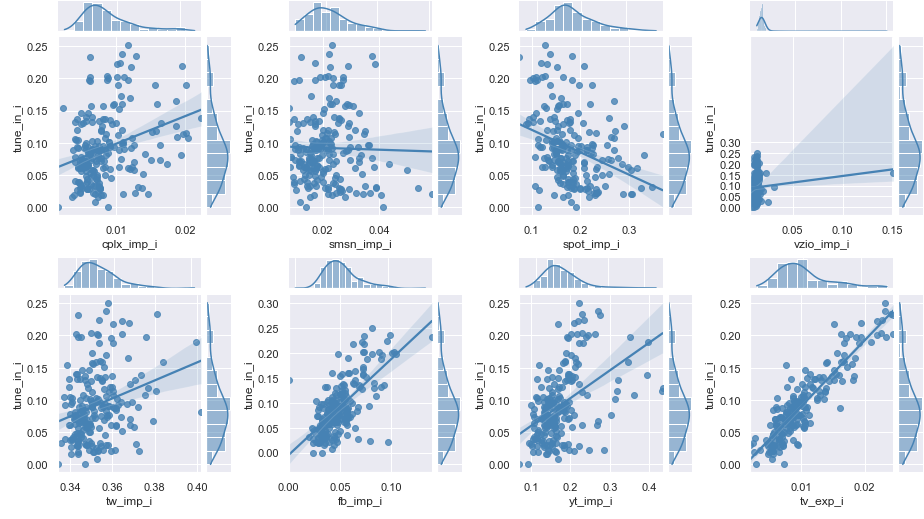

In [9]:
plot_relationship(data, 'tune_in_i')

## Building Multiple Bayesian Linear Model with pyMC3

In [10]:
x = data.iloc[:,:-1].values
y = data.tune_in_i.values

In [11]:
with pm.Model() as model_mlr_normal:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=25)
    # Slope
    beta = pm.Normal('beta', mu=0, sd=25, shape= len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 25)
    # Expected value of outcome (MLR with vectors)
    mu =  alpha + pm.math.dot(x, beta)
    # Likelihood
    tune_in_i = pm.Normal('tune_in_i', mu= mu, sd= eps, observed= y)
    
    # posterior/create the race
    trace_mlr_normal = pm.sample(chains= 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 283 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Convergence  Check

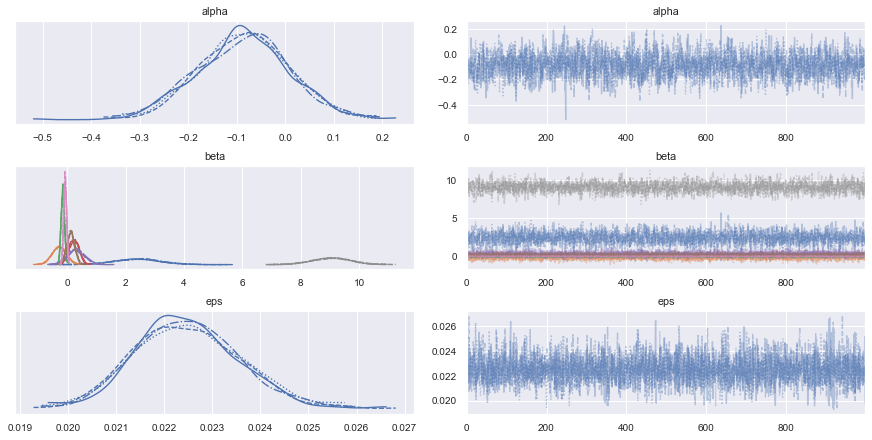

In [12]:
az.plot_trace(trace_mlr_normal)
plt.show()

In [13]:
trace_mlr_normal.varnames

['alpha', 'beta', 'eps_log__', 'eps']

In [14]:
# Lets look at slope coeficients
az.summary(trace_mlr_normal, var_names = ['beta']).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,2.380,0.771,0.906,3.803,0.016,0.011,2298.0,2727.0,1.0
smsn_imp_i,-0.282,0.239,-0.723,0.166,0.004,0.003,3366.0,2798.0,1.0
spot_imp_i,-0.157,0.059,-0.263,-0.043,0.001,0.001,2293.0,2582.0,1.0
vzio_imp_i,0.232,0.170,-0.096,0.539,0.003,0.002,3718.0,2341.0,1.0
tw_imp_i,0.296,0.289,-0.238,0.835,0.006,0.005,2154.0,2358.0,1.0
fb_imp_i,0.116,0.137,-0.137,0.376,0.002,0.002,3026.0,2922.0,1.0
yt_imp_i,-0.080,0.049,-0.169,0.012,0.001,0.001,3243.0,2977.0,1.0
tv_exp_i,9.050,0.652,7.819,10.277,0.013,0.010,2369.0,2023.0,1.0


In [15]:
# Lets look at the slope and error
az.summary(trace_mlr_normal, var_names = ['alpha','eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.085,0.093,-0.264,0.084,0.002,0.001,2156.0,2373.0,1.0
eps,0.022,0.001,0.020,0.025,0.000,0.000,4389.0,2464.0,1.0


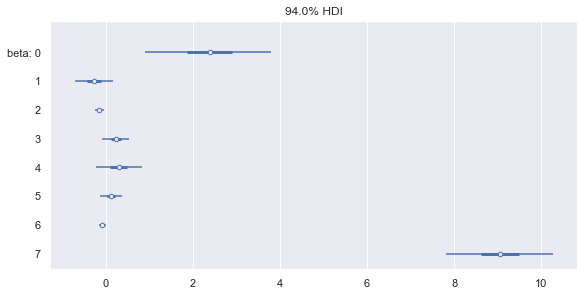

In [16]:
az.plot_forest(trace_mlr_normal, var_names=['beta'], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

In [17]:
# data_cplx_imp_i = data[[col for col in data.columns if col != 'tw_imp_i']]
# data_cplx_imp_i = data[[col for col in data.columns if col != 'cplx_imp_i']]

The following parameters have an Rhat greater 1.005:


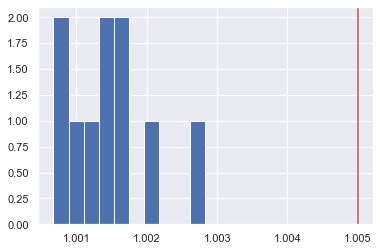

In [18]:
check_rhat(trace_mlr_normal, 1.005) # We should be consern if there is Rhat more then 0.1 !!!

In [19]:
# az.plot_pair(trace_mlr_normal, kind ='kde', fill_last= False)

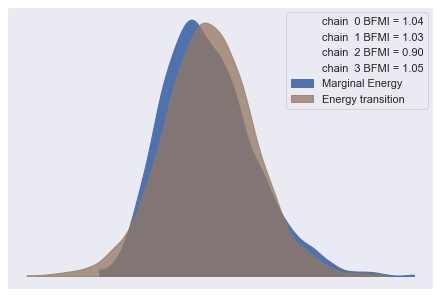

In [20]:
az.plot_energy(trace_mlr_normal)
plt.show()

### Posterior Predictions Check

In [21]:
## Look for predictions using posterior
ppc_mlr_normal = pm.sample_posterior_predictive(trace_mlr_normal, samples=100, model = model_mlr_normal)

R2 has well-known problems as a measure of model fit, but it can be a handy quick summary for
linear regressions and generalized linear models, and we would
like to produce it by default when fitting Bayesian regressions. Our preferred solution is to use (3):
predicted variance divided by predicted variance plus error variance. This measure is model based:
all variance terms come from the model, and not directly from the data.

In [22]:
az.r2_score(y, ppc_mlr_normal['tune_in_i'])

r2        0.825870
r2_std    0.019262
dtype: float64

In [23]:
pd.DataFrame(ppc_mlr_normal['tune_in_i']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.029849,0.020795,0.029588,0.061465,0.034051,0.053850,0.013265,0.015867,0.034694,0.074646,...,0.028740,0.089322,0.089946,0.035816,0.020813,0.042804,0.046678,0.060407,0.050825,0.049102
1,0.121506,0.160514,0.085599,0.121086,0.104689,0.129461,0.100763,0.083408,0.115456,0.083613,...,0.090909,0.132744,0.104583,0.117069,0.105774,0.114650,0.136488,0.141889,0.113994,0.110245
2,0.070029,0.027430,0.078044,0.060468,0.061148,0.063808,0.056804,0.046460,0.049526,0.080059,...,0.094057,0.082858,0.083115,0.053408,0.121909,0.090987,0.081587,0.024288,0.080400,0.056949
3,0.208980,0.269265,0.228953,0.229902,0.200945,0.219923,0.228071,0.218840,0.264412,0.192769,...,0.214821,0.210526,0.225486,0.220179,0.229926,0.195074,0.216450,0.219622,0.245026,0.243169
4,0.120014,0.091944,0.152779,0.142545,0.121308,0.145124,0.152993,0.096948,0.144635,0.141520,...,0.128673,0.139331,0.124729,0.123155,0.148834,0.144859,0.158803,0.180322,0.134027,0.180151


posterior predictive variable tune_in_i's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


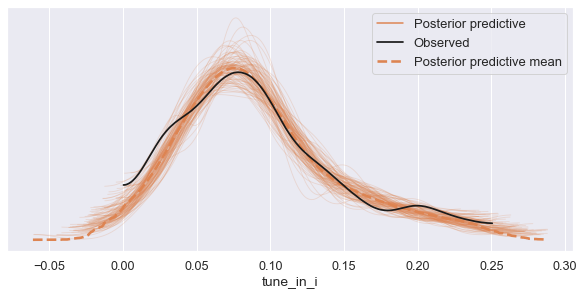

In [24]:
data_ppc_mlr_normal = az.from_pymc3(trace= trace_mlr_normal, posterior_predictive= ppc_mlr_normal)
ax = az.plot_ppc(data_ppc_mlr_normal, figsize=(8,4), mean= True, color='C1',)
ax.legend(fontsize= 13)
plt.show()

## Changing one of the prior slope cof to HalfFlat Distribution

In [41]:
with pm.Model() as model_mlr_half_normal:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=2)
    # Slope
    beta = pm.HalfFlat('beta', shape= len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 25)
    # Expected value of outcome (MLR with vectors)
    mu =  alpha + pm.math.dot(x, beta)
    # Likelihood
    tune_in_i = pm.Normal('tune_in_i', mu= mu, sd= eps, observed= y)
    
    # posterior/create the race
    trace_mlr_half_normal = pm.sample(chains= 4, tune = 2000, target_accept = 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 357 seconds.


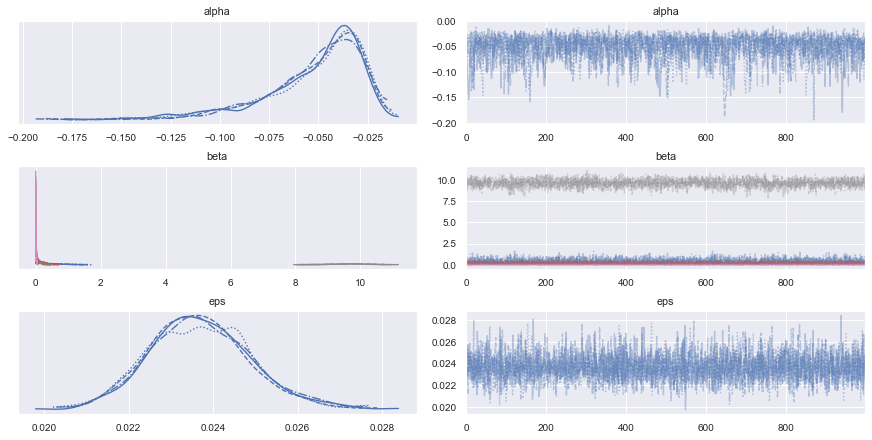

In [42]:
az.plot_trace(trace_mlr_half_normal)
plt.show()

In [43]:
# Lets look at slope coeficients
az.summary(trace_mlr_half_normal, var_names = ['beta']).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,0.398,0.288,0.000,0.911,0.005,0.004,1937.0,1484.0,1.0
smsn_imp_i,0.057,0.051,0.000,0.149,0.001,0.001,2007.0,1455.0,1.0
spot_imp_i,0.010,0.009,0.000,0.026,0.000,0.000,2909.0,1577.0,1.0
vzio_imp_i,0.197,0.130,0.000,0.424,0.002,0.002,2454.0,1309.0,1.0
tw_imp_i,0.081,0.072,0.000,0.217,0.002,0.002,1256.0,1285.0,1.0
fb_imp_i,0.113,0.083,0.000,0.262,0.002,0.001,1496.0,1026.0,1.0
yt_imp_i,0.010,0.010,0.000,0.028,0.000,0.000,2863.0,1605.0,1.0
tv_exp_i,9.666,0.458,8.828,10.521,0.010,0.007,2106.0,2253.0,1.0


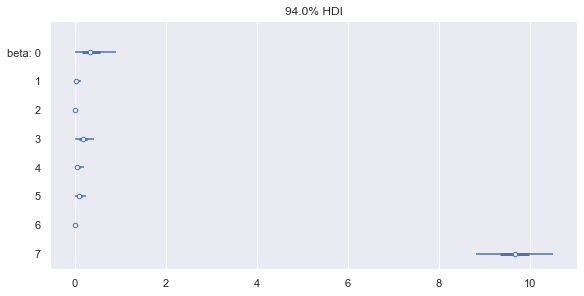

In [44]:
az.plot_forest(trace_mlr_half_normal, var_names=['beta'], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

In [45]:
## Look for predictions using posterior
ppc_mlr_half_normal = pm.sample_posterior_predictive(trace_mlr_half_normal, samples=100, model = model_mlr_half_normal)
az.r2_score(y, ppc_mlr_half_normal['tune_in_i'])

r2        0.805645
r2_std    0.025338
dtype: float64

posterior predictive variable tune_in_i's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


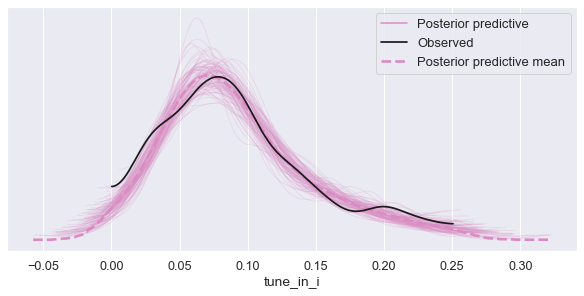

In [46]:
data_ppc_mlr_half_normal = az.from_pymc3(trace= trace_mlr_half_normal, posterior_predictive= ppc_mlr_half_normal)
ax = az.plot_ppc(data_ppc_mlr_half_normal, figsize=(8,4), mean= True, color='C6',)
ax.legend(fontsize= 13)
plt.show()

## Building Multiple Bayesian Linear Model with GLM

In [39]:
# Formula for Bayesian Linear Regression
formula = 'tune_in_i ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

# Context for the model
with pm.Model() as model_normal_glm:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    tune_in_i  = pm.GLM.from_formula(formula, data = data, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    trace_normal_glm = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 429 seconds.


In [40]:
var_names_glm = trace_normal_glm.varnames
var_names_glm

['Intercept', 'cplx_imp_i', 'smsn_imp_i', 'spot_imp_i', 'vzio_imp_i', 'tw_imp_i', 'fb_imp_i', 'yt_imp_i', 'tv_exp_i', 'sd_log__', 'sd']


### Convergence  Check

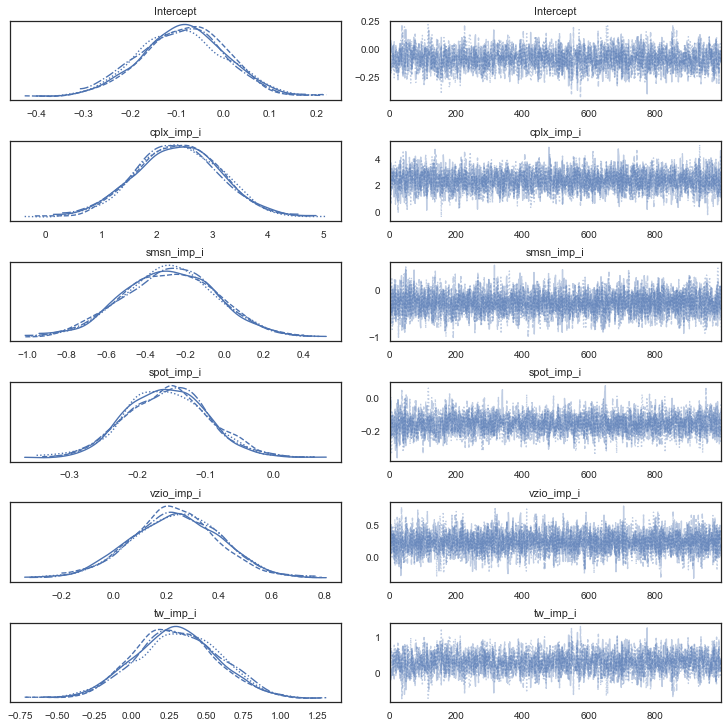

In [41]:
az.plot_trace(trace_normal_glm, figsize= (10,10), var_names = var_names_glm[:-5], )
plt.show()

In [42]:
az.summary(trace_normal_glm, var_names = var_names_glm[1:-2])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,2.376,0.748,0.984,3.756,0.014,0.010,2741.0,3057.0,1.0
smsn_imp_i,-0.277,0.236,-0.713,0.170,0.004,0.003,3843.0,2818.0,1.0
spot_imp_i,-0.157,0.060,-0.264,-0.040,0.001,0.001,2726.0,2443.0,1.0
vzio_imp_i,0.236,0.168,-0.070,0.559,0.003,0.002,4037.0,2876.0,1.0
tw_imp_i,0.298,0.283,-0.215,0.824,0.006,0.004,2047.0,2591.0,1.0
fb_imp_i,0.120,0.139,-0.141,0.374,0.002,0.002,3266.0,2663.0,1.0
yt_imp_i,-0.081,0.047,-0.165,0.012,0.001,0.001,3386.0,3003.0,1.0
tv_exp_i,9.050,0.643,7.804,10.238,0.013,0.009,2581.0,2674.0,1.0


In [43]:
# Lets look at the slope and error
az.summary(trace_normal_glm, var_names= var_names_glm[0])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.086,0.091,-0.253,0.087,0.002,0.001,2053.0,2576.0,1.0


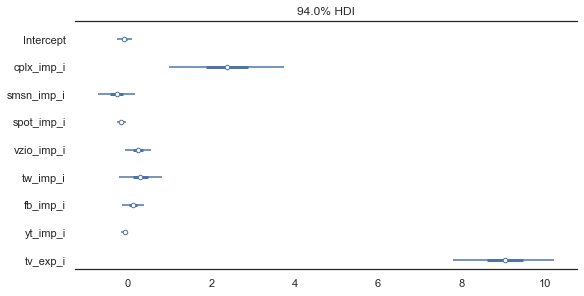

In [44]:
az.plot_forest(trace_normal_glm, var_names=var_names_glm[:-2], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

Multiple linear regression model reacts to redundant variables, there is importance of considering possible confounding variables.

The HPD for  coefficients is suspiciously wide. We can get a clue to what is going on with a scatter plot of the  coefficients:

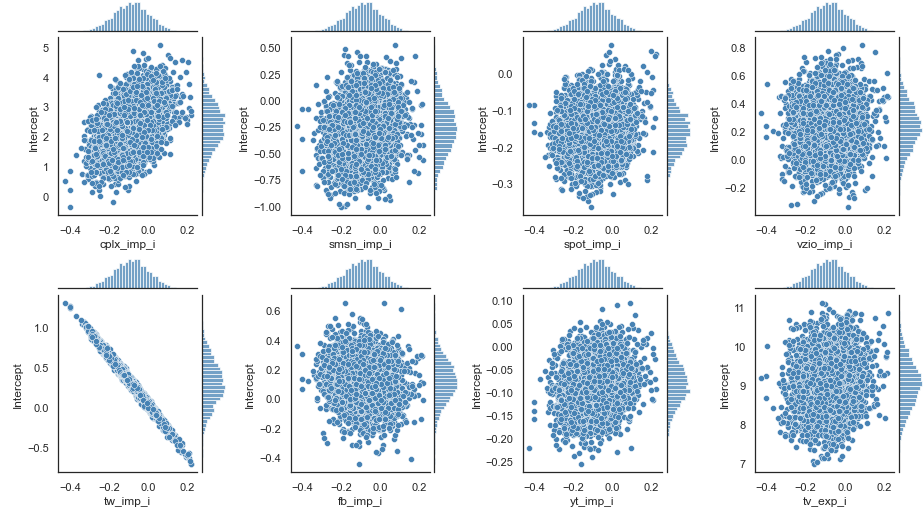

In [45]:
# Correlation between Intercept-oef and slope-coef for each channel 
plot_params_correlation(trace_normal_glm, trace_normal_glm.varnames[1:-2], 'Intercept')

### Posterior Predictions Check

In [46]:
## Look for predictions using posterior
ppc_normal_glm = pm.sample_posterior_predictive(trace_normal_glm, samples=100, model = model_normal_glm)

In [47]:
az.r2_score(y, ppc_normal_glm['y'])

r2        0.828203
r2_std    0.022707
dtype: float64

In [48]:
pd.DataFrame(ppc_normal_glm['y']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.054125,-0.004834,0.051894,0.019514,0.040887,0.018420,0.057335,0.057330,0.033011,0.039788,...,0.017548,0.033987,0.100733,0.068642,0.042555,0.009246,0.076146,0.017673,0.061804,0.020188
1,0.109769,0.088386,0.122198,0.059411,0.072794,0.137584,0.128267,0.119505,0.123577,0.087179,...,0.123369,0.092081,0.111447,0.100274,0.094551,0.105310,0.108025,0.086781,0.092073,0.104821
2,0.077720,0.085251,0.071175,0.071573,0.073669,0.071259,0.042286,0.038553,0.062370,0.065089,...,0.088915,0.060971,0.043362,0.088449,0.069692,0.034014,0.067220,0.123341,0.055017,0.044665
3,0.201712,0.200626,0.197339,0.221915,0.215516,0.178875,0.207302,0.221221,0.218788,0.209017,...,0.256393,0.213706,0.228401,0.233840,0.217799,0.262927,0.246805,0.236846,0.230411,0.231650
4,0.109252,0.113827,0.141047,0.115966,0.127258,0.153047,0.133571,0.151568,0.146529,0.153003,...,0.131289,0.142307,0.160456,0.166925,0.118828,0.114847,0.154434,0.144173,0.125383,0.140235


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


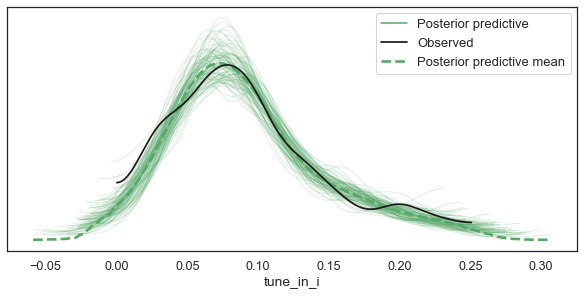

In [49]:
data_ppc_glm = az.from_pymc3(trace= trace_normal_glm, posterior_predictive= ppc_normal_glm)
ax = az.plot_ppc(data_ppc_glm, figsize=(8,4), mean= True, color='C2',)
ax.legend(fontsize= 13)
ax.set_xlabel('tune_in_i')
plt.show()

### Building GLM with StudentT distribution

In [204]:
# Context for the model
with pm.Model() as model_student:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=25)
    # Slope
    beta = pm.Normal('beta', mu=0, sd=25, shape= len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 25)
    # Expected value of outcome (MLR with vectors)
    mu =  alpha + pm.math.dot(x, beta)
    v_ = pm.Exponential('v_', 1/29)
    v = pm.Deterministic('v', v_ + 1)
    # Likelihood
    tune_in_i = pm.StudentT('tune_in_i', mu= mu, sd= eps, nu=v, observed= y)
    
    trace_student = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [v_, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 325 seconds.


### Convergency check

In [205]:
var_student_glm = trace_student.varnames

In [206]:
var_student_glm

['alpha', 'beta', 'eps_log__', 'v__log__', 'eps', 'v_', 'v']

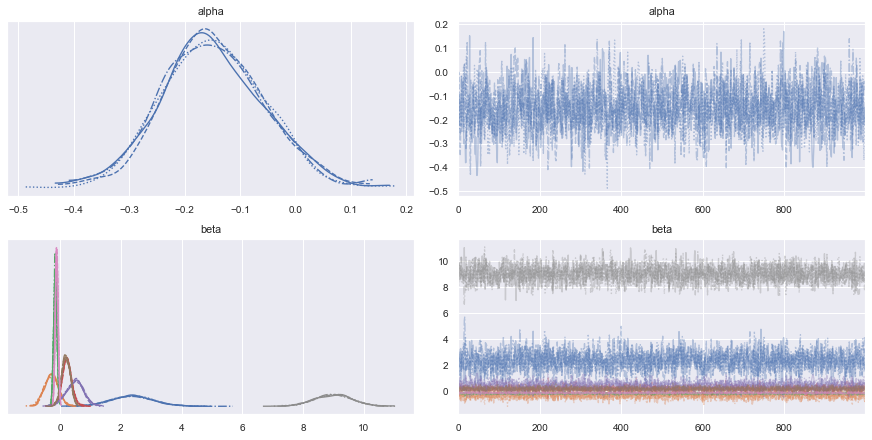

In [207]:
az.plot_trace(trace_student, figsize= (12,6), var_names = var_student_glm[:2],)
plt.show()

In [208]:
# Lets look at slope coeficients
az.summary(trace_student, var_names = ['beta']).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,2.370,0.697,1.068,3.699,0.015,0.011,2269.0,2235.0,1.0
smsn_imp_i,-0.289,0.224,-0.706,0.125,0.005,0.003,2478.0,2869.0,1.0
spot_imp_i,-0.158,0.052,-0.253,-0.061,0.001,0.001,2162.0,2744.0,1.0
vzio_imp_i,0.225,0.163,-0.086,0.534,0.003,0.002,3681.0,2321.0,1.0
tw_imp_i,0.484,0.284,-0.062,0.997,0.007,0.005,1562.0,1676.0,1.0
fb_imp_i,0.191,0.139,-0.072,0.448,0.003,0.002,2804.0,2510.0,1.0
yt_imp_i,-0.112,0.045,-0.193,-0.022,0.001,0.001,2594.0,2293.0,1.0
tv_exp_i,9.000,0.603,7.859,10.128,0.012,0.009,2402.0,2623.0,1.0


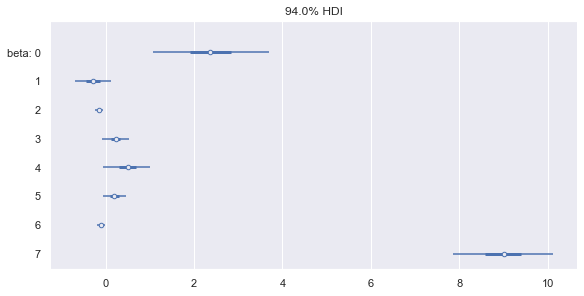

In [209]:
az.plot_forest(trace_student, var_names=['beta'], combined=True, colors='cycle',  figsize=(8,4))
plt.show()

### Posterior Predictions Check

In [210]:
## Look for predictions using posterior
ppc_student = pm.sample_posterior_predictive(trace_student, samples=100, model = model_student)
az.r2_score(y, ppc_student['tune_in_i'])

r2        0.822192
r2_std    0.042776
dtype: float64

In [211]:
pd.DataFrame(ppc_student['tune_in_i']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.060361,0.048947,0.031672,0.054217,0.020902,0.022936,0.060422,0.025300,0.016641,0.039887,...,0.057610,-0.010210,0.024862,0.055877,0.043314,0.072087,0.061622,0.054095,0.039310,0.048730
1,0.104352,0.102341,0.100437,0.119745,0.106464,0.097065,0.094747,0.095975,0.117586,0.098258,...,0.120678,0.109101,0.132738,0.123235,0.116723,0.146760,0.130296,0.090578,0.097063,0.155204
2,0.083444,0.085572,0.088395,0.037234,0.062070,0.046082,0.073608,0.043560,0.076241,0.064854,...,0.077943,0.064356,0.076474,0.087900,0.059517,0.100466,0.073446,0.095867,0.078194,0.094708
3,0.212818,0.219577,0.316767,0.221421,0.236280,0.219761,0.209426,0.191617,0.179614,0.212117,...,0.225401,0.230866,0.212769,0.254433,0.230306,0.231790,0.219397,0.256909,0.242398,0.259399
4,0.151286,0.136408,0.148228,0.142029,0.137733,0.130533,0.138587,0.141774,0.134686,0.148661,...,0.117414,0.111394,0.125938,0.156399,0.164598,0.146116,0.138607,0.151977,0.151063,0.128210


posterior predictive variable tune_in_i's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


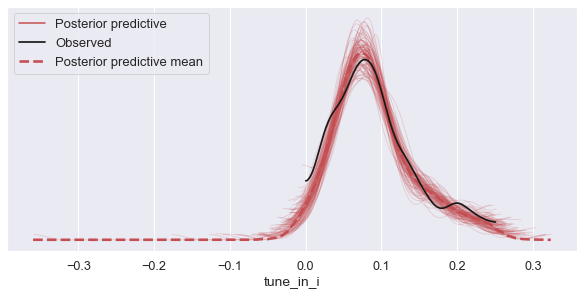

In [212]:
data_ppc_student = az.from_pymc3(trace= trace_student, posterior_predictive= ppc_student)
ax = az.plot_ppc(data_ppc_student, figsize=(8,4), mean= True, color='C3',)
ax.legend(fontsize= 13)
ax.set_xlabel('tune_in_i')
plt.show()

## Models Comparison

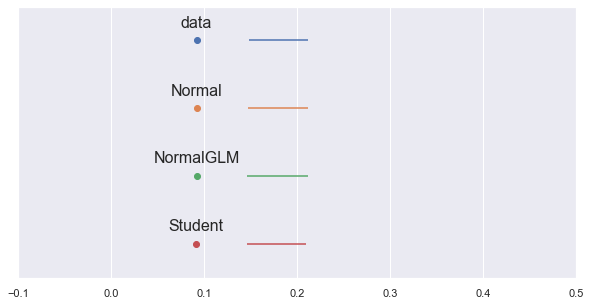

In [213]:
plt.figure(figsize=(10, 5))
ppc_data = [y,
            ppc_mlr_normal['tune_in_i'],
            ppc_normal_glm['y'], 
            ppc_student['tune_in_i'],]

labels = ['data', 'Normal', 'NormalGLM', 'Student']
for i, d in enumerate(ppc_data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=16)
    plt.ylim([-i-0.5, 0.5])
    plt.xlim([-0.1, 0.5])
    plt.yticks([])

The preceding diagram shows the mean and the interquartile range (IQR) for the data(Blue), MLR_Normal(Orange) and GLM_Normal(Green). In this diagram, we are averaging over the posterior predictive samples for each model. We can see that the mean is (on average) well reproduced for both models, and that the interquantile range is in line with real data.

### Dispersion of both the mean and the interquartile range, as opposed to their mean values

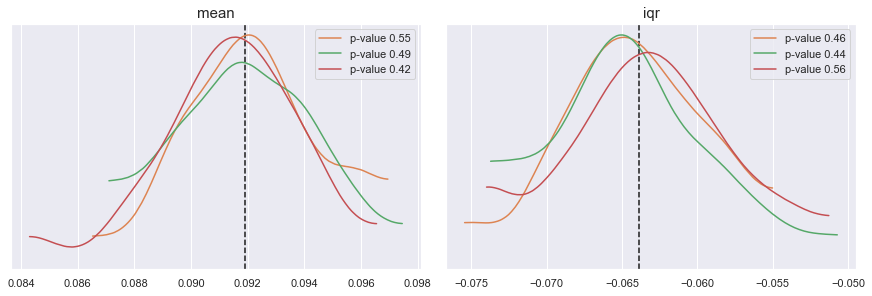

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

def iqr(k, a=0):
    # calculate range
    return np.subtract(*np.percentile(k, [25, 75], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    
    for d_sim, c in zip([ppc_mlr_normal['tune_in_i'], 
                         ppc_normal_glm['y'], 
                         ppc_student['tune_in_i'] 
                        ],
                        ['C1', 'C2', 'C3']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
        label=f'p-value {p_value:.2f}', ax=ax[idx])
        ax[idx].set_title(func.__name__, size =15)
        ax[idx].set_yticks([])
        ax[idx].legend()

Black dashed line represents the statistic computed from the data (either the mean or the IQR).The curves represent the distribution of the mean (left panel) or interquartile range (right panel) that was computed from the posterior predictive samples. You may have also noted that Figure 5.4 also includes values labeled as P-values. 


We compute such P-values by comparing the simulated data to the actual data.


For both sets, we compute a summary statistic (the mean or IQR, in this example), and then we count the proportion of times the summary statistics from the simulation is equal or greater than the one computed from the data.


If the data and simulation agrees, we should expect a P-value around 0.5, otherwise we are in the presence of a biased posterior predictive distribution.

## Masking effect variables
    

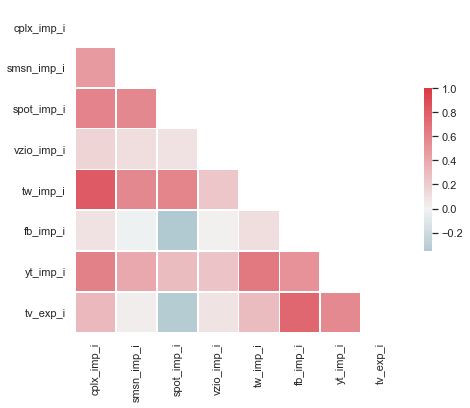

Based on threshold 0.8 , sugested featrures to drop - ['cplx_imp_i', 'tw_imp_i']


,cplx_imp_i,tw_imp_i
cplx_imp_i,1.000000,0.812304
tw_imp_i,0.812304,1.000000


In [74]:
features_corr_matrix(data.iloc[:,:-1], 0.8, matrix= True)

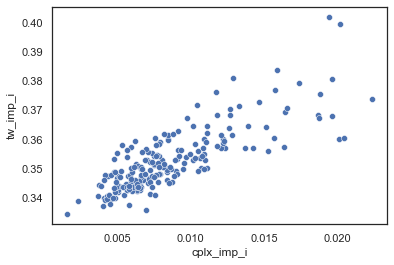

In [75]:
sns.scatterplot(data.cplx_imp_i, data.tw_imp_i)
plt.show()

#### Building 3 different GLM models. m1_cpix_imp_i_tw_imp_i will have all the features, m2__cpix_imp_i will have one of the corr feature excluded and m3_tw_imp_i will have second of corr feature excluded 

In [83]:
data_cplx_imp_i = data[[col for col in data.columns if col != 'tw_imp_i']]
data_tw_imp_i = data[[col for col in data.columns if col != 'cplx_imp_i']]

# naming each df
data.name = 'data'
data_cplx_imp_i.name = 'data_cplx_imp_i'
data_tw_imp_i.name = 'data_tw_imp_i'

In [84]:
data_sets = [data, data_cplx_imp_i, data_tw_imp_i]

In [85]:
indiv_traces= {}

for df in data_sets:
    # build the formula based on a features from data set
    formula = 'tune_in_i ~ ' + ' + '.join(['%s' % variable for variable in df.columns[:-1]])
    # Context for the model
    with pm.Model() as individual_model:

        # The prior for the model parameters will be a normal distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        tune_in_i= pm.GLM.from_formula(formula, data = df, family = family)

        # Perform Markov Chain Monte Carlo sampling
        trace = pm.sample(chains = 4, target_accept = 0.9)
        
    indiv_traces[df.name] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 266 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 362 seconds.


In [86]:
indiv_traces

{'data': <MultiTrace: 4 chains, 1000 iterations, 11 variables>,
 'data_cplx_imp_i': <MultiTrace: 4 chains, 1000 iterations, 10 variables>,
 'data_tw_imp_i': <MultiTrace: 4 chains, 1000 iterations, 10 variables>}

Take a look at the  parameters for these models. Using a forest plot, we can compare them in a single plot:

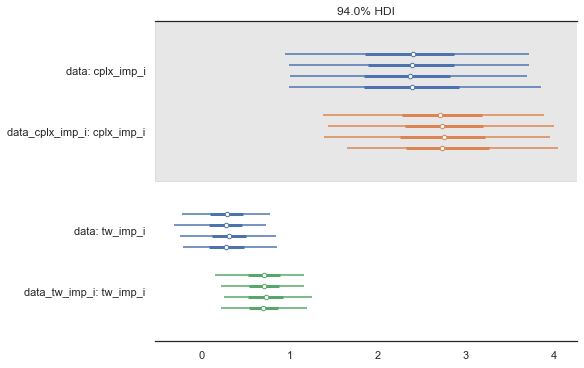

In [87]:
az.plot_forest([indiv_traces['data'], indiv_traces['data_cplx_imp_i'], indiv_traces['data_tw_imp_i']],
               model_names=[data.name, data_cplx_imp_i.name, data_tw_imp_i.name],
               var_names=['cplx_imp_i', 'tw_imp_i'],
               combined=False, colors='cycle', figsize=(8, 5), )
plt.show()

The HPD for coefficients is suspiciously wide. We can get a clue to what is going on with a scatter plot of the coefficients:

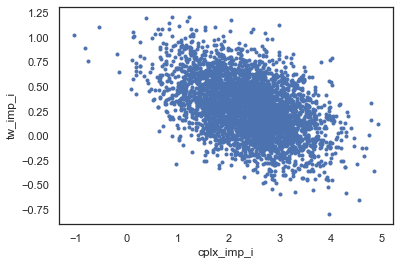

In [88]:
az.plot_pair(indiv_traces['data'], var_names=['cplx_imp_i','tw_imp_i'])
plt.show()

The marginal posterior for  is narrowing diagonal. When one coefficient goes up, the other must go down. Both are correlated. This is just a consequence of the model and the data.

### Slopes Coeficients with Features Interaction (Confounding variables in data set)

In [89]:
df_data = pd.DataFrame(az.summary(indiv_traces['data'])['mean']).rename(columns={'mean':'mean_data'})
df_data_cplx_imp_i = pd.DataFrame(az.summary(indiv_traces['data_cplx_imp_i'])['mean']).rename(columns={'mean':'mean_data_cplx_imp_i'})
df_data_tw_imp_i = pd.DataFrame(az.summary(indiv_traces['data_tw_imp_i'])['mean']).rename(columns={'mean':'mean_data_tw_imp_i'})

df_results = df_data.join(df_data_cplx_imp_i).join(df_data_tw_imp_i)

In [90]:
def pct_change(col1,col2):
    return round(((abs(col2) - abs(col1)) / col1) * 100,2)

In [91]:
# calculate pct change of intercept and slopes

df_results['change_%_cplx_imp_i'] =pct_change(df_results['mean_data'], df_results['mean_data_cplx_imp_i'])
df_results['change_%_tw_imp_i'] =pct_change(df_results['mean_data'], df_results['mean_data_tw_imp_i'])

df_results

,mean_data,mean_data_cplx_imp_i,mean_data_tw_imp_i,change_%_cplx_imp_i,change_%_tw_imp_i
Intercept,-0.083,0.010,-0.229,87.95,-175.90
cplx_imp_i,2.366,2.743,NaN,15.93,NaN
smsn_imp_i,-0.283,-0.235,-0.355,16.96,-25.44
spot_imp_i,-0.155,-0.145,-0.087,6.45,43.87
vzio_imp_i,0.238,0.255,0.206,7.14,-13.45
tw_imp_i,0.288,NaN,0.712,NaN,147.22
fb_imp_i,0.119,0.105,0.054,-11.76,-54.62
yt_imp_i,-0.080,-0.070,-0.067,12.50,16.25
tv_exp_i,9.061,9.163,9.736,1.13,7.45
sd,0.022,0.022,0.023,0.00,4.55


In [92]:
df_results.loc[['cplx_imp_i', 'tw_imp_i']]

,mean_data,mean_data_cplx_imp_i,mean_data_tw_imp_i,change_%_cplx_imp_i,change_%_tw_imp_i
cplx_imp_i,2.366,2.743,NaN,15.93,NaN
tw_imp_i,0.288,NaN,0.712,NaN,147.22


Results interpretation:
    
    Without tw_imp_i in our data set slope of cpix_imp_i higer on 16%
    Without cpix_imp_i in our data set slope of tw_imp_i higer on 147%

    In any real dataset, correlations are going to exist to some degree. How strong should two or more variables be correlated to become a problem?

    It is always possible to do a correlation matrix before running any Bayesian model and check for variables with a high correlation of, let's say, above 0.9 or so.
    
    Nevertheless, the problem with this approach is that what really matters is not the pairwise correlations we can observe in a correlation matrix, but the correlation of the variables inside a model, and as we already saw, variables behave differently in isolation than when they are put together in a model. 
    
    Two or more variables can increase or decrease their correlation when put in the context of other variables in a multiple regression model. As always, careful inspection of the posterior together with an iterative critical approach to model building are highly recommended and can help us to spot problems and understand the data and models.

## Modifying the data before running model with StandardScaler

In [230]:
from sklearn.preprocessing import StandardScaler
scaller = StandardScaler()

In [337]:
data_scaled = pd.DataFrame(scaller.fit_transform(data.iloc[:,:-1]), columns= data.columns[:-1])
data_scaled['tune_in_i'] = data['tune_in_i']

In [232]:
# Context for the model
with pm.Model() as model_normal_glm_scaled:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    tune_in_i  = pm.GLM.from_formula(formula, data = data_scaled, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    trace_normal_glm_scaled = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, tv_exp_i, yt_imp_i, fb_imp_i, tw_imp_i, vzio_imp_i, spot_imp_i, smsn_imp_i, cplx_imp_i, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


In [235]:
az.summary(trace_normal_glm_scaled, var_names = trace_normal_glm_scaled.varnames[1:-2])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cplx_imp_i,0.009,0.003,0.003,0.015,0.0,0.0,4036.0,3033.0,1.0
smsn_imp_i,-0.002,0.002,-0.006,0.001,0.0,0.0,4696.0,2671.0,1.0
spot_imp_i,-0.008,0.003,-0.014,-0.002,0.0,0.0,3844.0,2926.0,1.0
vzio_imp_i,0.002,0.002,-0.001,0.005,0.0,0.0,6101.0,2457.0,1.0
tw_imp_i,0.003,0.003,-0.003,0.009,0.0,0.0,4251.0,3039.0,1.0
fb_imp_i,0.002,0.003,-0.003,0.007,0.0,0.0,4398.0,3191.0,1.0
yt_imp_i,-0.005,0.003,-0.010,0.000,0.0,0.0,5351.0,3280.0,1.0
tv_exp_i,0.043,0.003,0.037,0.049,0.0,0.0,3598.0,2553.0,1.0


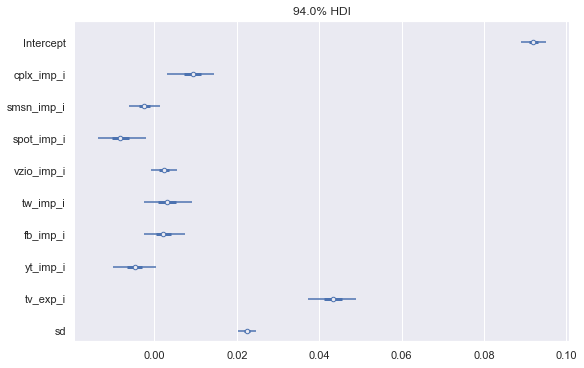

In [336]:
az.plot_forest(trace_normal_glm_scaled, figsize= (8,5), combined=True)
plt.show()

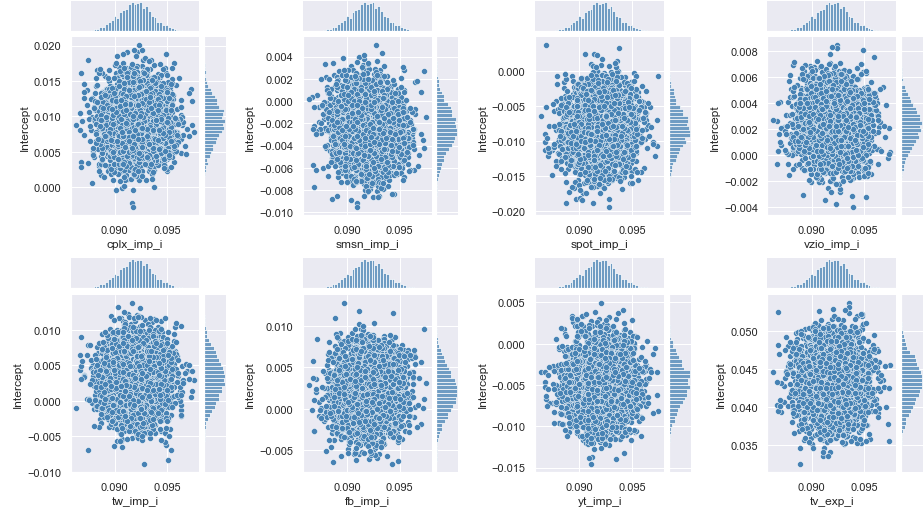

In [237]:
# Correlation between Intercept-oef and slope-coef for each channel 
plot_params_correlation(trace_normal_glm_scaled, trace_normal_glm_scaled.varnames[1:-2], 'Intercept')

In [238]:
## Look for predictions using posterior
ppc_normal_glm_scaled = pm.sample_posterior_predictive(trace_normal_glm_scaled, samples=100, model = model_normal_glm_scaled)

In [239]:
az.r2_score(y, ppc_normal_glm_scaled['y'])

r2        0.821905
r2_std    0.022221
dtype: float64

posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


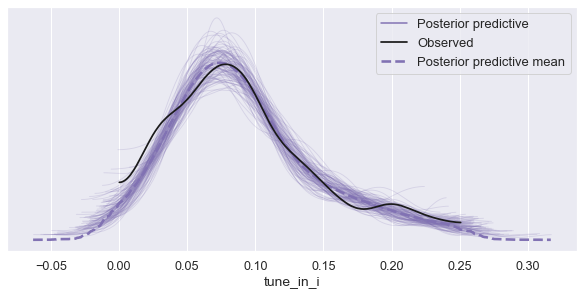

In [240]:
data_ppc_glm_scaled = az.from_pymc3(trace= trace_normal_glm_scaled, posterior_predictive= ppc_normal_glm_scaled)
ax = az.plot_ppc(data_ppc_glm_scaled, figsize=(8,4), mean= True, color='C4',)
ax.legend(fontsize= 13)
ax.set_xlabel('tune_in_i')
plt.show()

## How Much Each Channel contribute to the Target?

    An easy and fairly common method for estimating relative importance is to express each regression coefficient as a percentage of the sum of the coefficients.
        
    Based on understanding how much of the variance in target variable can be attributed to particular predictor variables
    
    Collinearity among predictors does impact the significance, direction, and magnitude of coefficients

In [241]:
data.head()

,cplx_imp_i,smsn_imp_i,spot_imp_i,vzio_imp_i,tw_imp_i,fb_imp_i,yt_imp_i,tv_exp_i,tune_in_i
0,0.008422,0.015025,0.212211,0.013772,0.348791,0.023189,0.119566,0.005713,0.050437
1,0.016431,0.036270,0.225445,0.007491,0.369489,0.046153,0.184742,0.010343,0.097058
2,0.006553,0.015509,0.178028,0.011686,0.344432,0.037104,0.141722,0.008395,0.132308
3,0.010626,0.017485,0.119478,0.013206,0.353738,0.095669,0.236077,0.022665,0.223991
4,0.016560,0.025442,0.204707,0.010759,0.370823,0.046618,0.321395,0.015143,0.130586


In [242]:
model_formula = 'tune_in_i = '
for variable in trace_normal_glm.varnames[:-2]:
    model_formula += ' %0.2f * %s +' % (np.mean(trace_normal_glm[variable]), variable)
f = ' '.join(model_formula.split(' ')[:-1])
f

'tune_in_i =  -0.09 * Intercept + 2.38 * cplx_imp_i + -0.28 * smsn_imp_i + -0.16 * spot_imp_i + 0.24 * vzio_imp_i + 0.30 * tw_imp_i + 0.12 * fb_imp_i + -0.08 * yt_imp_i + 9.05 * tv_exp_i'

variation of target = sum of alll coef_prdictor * variation_predictor

In [278]:
def calculate_contribution(trace, plot = True, summary = False, standardized = False):
    
    var_names = trace.varnames
    df_summary = az.summary(trace, var_names = var_names[1:-2])[['mean','sd']]
    df_summary['mean2'] = df_summary['mean'].apply(lambda x: x*x)
    
    if standardized:
        df_summary['sd2'] = 1
    else: 
        df_summary['sd2'] = df_summary['sd'].apply(lambda x: x*x)
    df_summary['mean2*sd2'] =  df_summary.mean2*df_summary.sd2
    
    pcts = list(zip(df_summary.index, 
                [round(value/sum(df_summary['mean2*sd2'])*100, 
                       5) for value in df_summary['mean2*sd2'].values]))
    
    df_summary['contribution_pct'] = [x[1] for x in pcts]
    
    if plot:
        
        #Seaborn Horizontal barplot
        sns.set_style("darkgrid")
        bar,ax = plt.subplots(figsize=(8,4))
        ax = sns.barplot(x="contribution_pct", y=df_summary.index, data=df_summary, ci=None, palette="muted",orient='h' )
        ax.set_title("Contribution to tune_in_i", fontsize=15)
        ax.set_xlabel ("Percentage")
        ax.set_ylabel ("Channel Type")
        for rect in ax.patches:
            ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

        # bar.savefig("Seaborn_Bar_Vertical.png");
    if summary:
        return df_summary

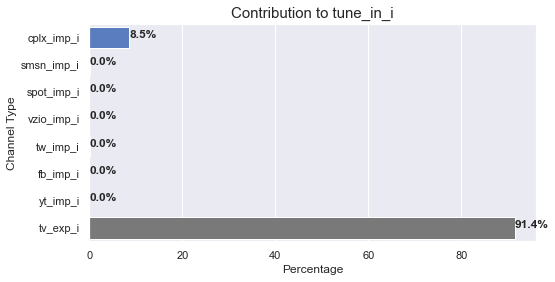

In [279]:
calculate_contribution(trace_normal_glm)

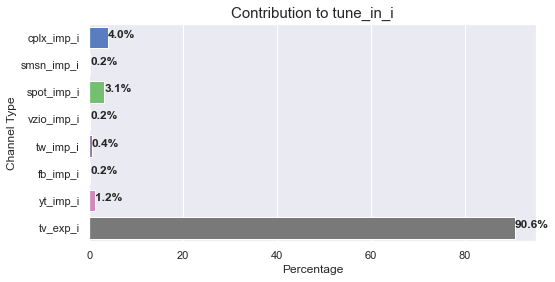

In [281]:
calculate_contribution(trace_normal_glm_scaled, standardized=True)

In [328]:
df_contr_norm = calculate_contribution(trace_normal_glm, plot= False, summary= True)
df_contr_scaled = calculate_contribution(trace_normal_glm_scaled, plot= False, summary= True)

df_contr_norm = df_contr_norm.rename(columns=
                                     {'mean':'Unstandardized', 'contribution_pct':'RI_Traditional_pct'})\
                                    [['Unstandardized','RI_Traditional_pct']]
df_contr_scaled = df_contr_scaled.rename(columns=
                                     {'mean':'Standardized', 'contribution_pct':'RI_Traditional(std)_pct'})\
                                    [['Standardized','RI_Traditional(std)_pct']]

In [329]:
df_contr_norm.join(df_contr_scaled)[['Unstandardized','Standardized','RI_Traditional_pct','RI_Traditional(std)_pct']]

,Unstandardized,Standardized,RI_Traditional_pct,RI_Traditional(std)_pct
cplx_imp_i,2.376,0.009,8.52884,3.97926
smsn_imp_i,-0.277,-0.002,0.01154,0.08734
spot_imp_i,-0.157,-0.008,0.00024,3.14410
vzio_imp_i,0.236,0.002,0.00424,0.08734
tw_imp_i,0.298,0.003,0.01920,0.44214
fb_imp_i,0.120,0.002,0.00075,0.19651
yt_imp_i,-0.081,-0.005,0.00004,1.22817
tv_exp_i,9.050,0.043,91.43514,90.83515


Looking at the results, we can immediately spot some problems. First of all, the unstandardised and standardised solutions give dramatically different results. In other words, the method does not account for the way in which the variables are scaled.

### An Alternative (Model-Based) Method

## Relative Importance Analysis

In [334]:
data_scaled[data_scaled.columns[:3]].corr()

,cplx_imp_i,smsn_imp_i,spot_imp_i
cplx_imp_i,1.000000,0.477405,0.593644
smsn_imp_i,0.477405,1.000000,0.571028
spot_imp_i,0.593644,0.571028,1.000000


In [330]:
corr = data_scaled[['cplx_imp_i', 'tw_imp_i']].corr().iloc[0,1]
corr

0.8123040353185697

In [327]:
2*corr*0.009*0.003

4.386441790720276e-05

In [513]:
# variance accounted for by cplx_imp_i:
var_cplx_imp_i = np.square(2.376)*np.square(0.298)

In [514]:
# variance accounted for by tw_imp_i:

var_tw_imp_i = np.square(0.299)*np.square(0.291)

In [516]:
# shared variance that cannot be apportioned either to cplx_imp_i of tw_imp_i
2*cov*0.299*2.366

4.837062859653011e-05

In [522]:
# shared variance that apportioned to cplx_imp_i

var_cplx_imp_i/(var_cplx_imp_i+var_tw_imp_i)  # of 

0.9976268547869999